# **Trabalho 1 - SCC0252 (Visualização Computacional)**

- Luísa Balleroni Shimabucoro - 11832385
- Wictor Dalbosco Silva - 11871027

## **Importando as bibliotecas e carregando o dataset**

In [ ]:
import numpy as np
import pandas as pd
import pandas_profiling
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly

import plotly.express as px
from wordcloud import WordCloud
from collections import Counter
from sklearn.decomposition import PCA

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

O Dataset escolhido foi o [IMDB Movies Dataset](https://www.kaggle.com/datasets/harshitshankhdhar/imdb-dataset-of-top-1000-movies-and-tv-shows), sendo ele composto por dados dos top 1000 filmes e programas de TV presentes no IMBd (Internet Movie Database), a maior base de dados do gênero online.
<br>
<br>
O dataset é composto por 1000 instâncias e possui 16 atributos:
- **Poster_link** - link para a imagem do poster usado pelo IMBd
- **Series_Title** - nome do filme
- **Release_Year** - ano em que foi lançado
- **Certificate** - certificado ganho pelo filme
- **Runtime** - tempo de duração do filme (em minutos)
- **Genre** - gênero do filme
- **IMDB_Rating** - nota do filme no site do IMDb
- **Overview** - resumo do filme
- **Meta_score** - nota do filme no Metacritic
- **Director** - nome do diretor
- **Star1, Star2, Star3, Star4** - nome das estrelas do filme
- **No_of_Votes** - quantidades de votos do filme
- **Gross** - quando dinheiro o filme arrecadou

In [ ]:
# leitura do dataset a partir do csv (considerando que ele está no mesmo diretório do notebook)
dataset = pd.read_csv("./imdb_top_1000.csv")
# dataset = pd.read_csv("https://raw.githubusercontent.com/peetck/IMDB-Top1000-Movies/master/IMDB-Movie-Data.csv")


In [ ]:
dataset.shape

(1000, 16)

In [ ]:
dataset.sample(5)

,Poster_Link,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
853,https://m.media-amazon.com/images/M/MV5BMzdhMT...,Dirty Harry,1971,A,102 min,"Action, Crime, Thriller",7.7,"When a madman calling himself ""the Scorpio Kil...",90.0,Don Siegel,Clint Eastwood,Andrew Robinson,Harry Guardino,Reni Santoni,143292,"35,900,000"
712,https://m.media-amazon.com/images/M/MV5BM2I1YW...,Shadow of a Doubt,1943,PG,108 min,"Film-Noir, Thriller",7.8,"A young girl, overjoyed when her favorite uncl...",94.0,Alfred Hitchcock,Teresa Wright,Joseph Cotten,Macdonald Carey,Henry Travers,59556,NaN
113,https://m.media-amazon.com/images/M/MV5BMTY3Mj...,A Clockwork Orange,1971,A,136 min,"Crime, Drama, Sci-Fi",8.3,"In the future, a sadistic gang leader is impri...",77.0,Stanley Kubrick,Malcolm McDowell,Patrick Magee,Michael Bates,Warren Clarke,757904,"6,207,725"
770,https://m.media-amazon.com/images/M/MV5BNTEzOT...,Control,2007,R,122 min,"Biography, Drama, Music",7.7,"A profile of Ian Curtis, the enigmatic singer ...",78.0,Anton Corbijn,Sam Riley,Samantha Morton,Craig Parkinson,Alexandra Maria Lara,61609,"871,577"
1,https://m.media-amazon.com/images/M/MV5BM2MyNj...,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411"


## **Pré-processamento**

### Lidando com missing values

A primeira coisa que iremos fazer é verificar que tipos de dados estão presentes no Dataset, buscar por missing-values e escolher a melhor estratégia para lidar com eles.

Pela descrição dos dados é possível ver que existem algumas colunas com dados faltando, em específico a `Certificate` (composta por strings que identificam a faixa etária liberada para aquele filme), `Meta_score` (float64 que define uma nota de 0 a 100) e `Gross` (string que representa quanto dinheiro o filme faturou).



In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Poster_Link    1000 non-null   object 
 1   Series_Title   1000 non-null   object 
 2   Released_Year  1000 non-null   object 
 3   Certificate    899 non-null    object 
 4   Runtime        1000 non-null   object 
 5   Genre          1000 non-null   object 
 6   IMDB_Rating    1000 non-null   float64
 7   Overview       1000 non-null   object 
 8   Meta_score     843 non-null    float64
 9   Director       1000 non-null   object 
 10  Star1          1000 non-null   object 
 11  Star2          1000 non-null   object 
 12  Star3          1000 non-null   object 
 13  Star4          1000 non-null   object 
 14  No_of_Votes    1000 non-null   int64  
 15  Gross          831 non-null    object 
dtypes: float64(2), int64(1), object(13)
memory usage: 125.1+ KB


Para o atributo `Certificate` existem 16 possíveis classificações etárias (demonstração abaixo), porém como essas classificações dependem do país onde o filme será exibido, sendo que [cada país](https://help.imdb.com/article/contribution/titles/certificates/GU757M8ZJ9ZPXB39?ref_=helpart_nav_27#uae) possui siglas diferentes para indicar essas classificações. Como não possuímos informações sobre a quais países essas siglas se referem sua interpretabilidade fica comprometida, logo vamos remover essa coluna do conjunto de dados.

In [ ]:
dataset['Certificate'].value_counts()

U           234
A           197
UA          175
R           146
PG-13        43
PG           37
Passed       34
G            12
Approved     11
TV-PG         3
GP            2
TV-14         1
16            1
TV-MA         1
Unrated       1
U/A           1
Name: Certificate, dtype: int64

In [ ]:
dataset.drop(columns=['Certificate'], inplace=True)

In [ ]:
dataset.columns

Index(['Poster_Link', 'Series_Title', 'Released_Year', 'Runtime', 'Genre',
       'IMDB_Rating', 'Overview', 'Meta_score', 'Director', 'Star1', 'Star2',
       'Star3', 'Star4', 'No_of_Votes', 'Gross'],
      dtype='object')

Para o atributo `Meta_score` podemos considerar algumas estratégias diferentes. Como o dataset é dos 1000 filmes melhor avaliados de todos os tempos no IMBd as suas instâncias estão ordenadas com base no atributo `IMBD_Rating`, que define as notas dadas no site do IMDb, logo, como `Meta_score` também define uma nota dada para aquele filme poderíamos considerar fazer uma interpolação de dados caso as duas notas estivessem correlacionadas, mas como é possível ver na tabela abaixo esse não é o caso, sendo que muitas vezes um filme pode possuir uma nota baixa no Metacritic e apresentar um rating no IMDb alto e vice-versa. Adicionalmente, outra possibilidade seria remover as instâncias em que os dados são nulos, porém a quantidade de dados nulos engloba mais que 10% dos dados, de maneira que perderíamos muitas informações caso eles fossem descartados. Po fim, uma terceira opção seria substituir os valores nulos pelo metascore mais frequente ou pela média de notas, de maneira que o valor escolhido fosse relativamente razoável para todos os dados com missing values. Para os dados em questão vamos utilizar a terceira opção.

In [ ]:
dataset.corr()

,IMDB_Rating,Meta_score,No_of_Votes
IMDB_Rating,1.000000,0.268531,0.494979
Meta_score,0.268531,1.000000,-0.018507
No_of_Votes,0.494979,-0.018507,1.000000


In [ ]:
dataset['Meta_score'] = dataset['Meta_score'].fillna(int(dataset['Meta_score'].mean()))

Para o atributo `Gross`, que indica quando o filme faturou a discussão é parecida com a do `Meta_score`, de maneira que nesse caso vamos também substituir os valores nulos pela média, além de transformar esse atributo em um valor numérico para facilitar a sua manipulação.

In [ ]:
# transformação da string em um valor numérico
dataset['Gross'] = dataset['Gross'].str.replace(',', '').astype(float)

In [ ]:
dataset['Gross'] = dataset['Gross'].fillna(int(dataset['Gross'].mean()))

Dessa forma, conseguimos lidar com todos os missing values.

In [ ]:
dataset.isna().sum()

Poster_Link      0
Series_Title     0
Released_Year    0
Runtime          0
Genre            0
IMDB_Rating      0
Overview         0
Meta_score       0
Director         0
Star1            0
Star2            0
Star3            0
Star4            0
No_of_Votes      0
Gross            0
dtype: int64

### Alterações extras

Ao analisar o dataset podemos notar alguns detalhes sobre os dados presentes. Por exemplo, o atributo `Runtime` é formado por variáveis categóricas, sendo que ele nada mais é do que a duração do filme em minutos, logo, uma modificação que pode ser realizada é a transformação dessa variável em uma variável numérica, de maneira a facilitar a sua análise posterior.

In [ ]:
dataset['Runtime'] = dataset['Runtime'].str.replace(' min', '').astype(float)

Outra observação que pode ser feita é que no atributo `Gender` é que o gênero principal e os secundários (quando eles existem) estão agrupados em um atributo só, formando uma string. Do ponto de vista da visualização de dados uma alteração interessante seria criar colunas diferentes para cada gênero, de maneira que ele pudessem ser analisados de maneira separada caso fosse de interesse e também para facilitar a divisão entre os diferentes gêneros.

In [ ]:
# criamos dataframe com os gêneros dos filmes separados
genre_df = dataset['Genre'].str.split(",", n=-1, expand=True)
genre_df.columns = ['G1','G2','G3']  

In [ ]:
genre_df.sample(5)

,G1,G2,G3
751,Action,Adventure,Thriller
627,Action,Comedy,Mystery
737,Action,Adventure,Sci-Fi
81,Mystery,Thriller,None
204,Comedy,Drama,Thriller


In [ ]:
# substituímos os valores nulos por "Undefined" já que nem todos os filmes
# possuem mais de um gênero atribuído a eles
genre_df.fillna("Undefined", inplace=True)

In [ ]:
genre_df['G1'].value_counts()

Drama        289
Action       172
Comedy       155
Crime        107
Biography     88
Animation     82
Adventure     72
Mystery       12
Horror        11
Western        4
Film-Noir      3
Fantasy        2
Family         2
Thriller       1
Name: G1, dtype: int64

In [ ]:
# retiramos a coluna onde o gênero dos filmes estão agrupados
dataset.drop(columns=['Genre'], inplace=True)

In [ ]:
# adicionamos as novas colunas que separam os gêneros dos filmes
dataset = pd.concat([dataset, genre_df], axis=1)

In [ ]:
dataset.head(2)

,Poster_Link,Series_Title,Released_Year,Runtime,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross,G1,G2,G3
0,https://m.media-amazon.com/images/M/MV5BMDFkYT...,The Shawshank Redemption,1994,142.0,9.3,Two imprisoned men bond over a number of years...,80.0,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2343110,28341469.0,Drama,Undefined,Undefined
1,https://m.media-amazon.com/images/M/MV5BM2MyNj...,The Godfather,1972,175.0,9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,134966411.0,Crime,Drama,Undefined


Por último, como o link do poster não será um dado útil para a análise e visualisação de dados podemos retirar essa coluna do nosso Dataset também.

In [ ]:
dataset.drop(columns=['Poster_Link'], inplace=True)

Dessa forma, o nosso dataset final, depois de ser pré-processado, fica com a seguinte aparência:

In [ ]:
dataset.sample(5)

,Series_Title,Released_Year,Runtime,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross,G1,G2,G3
498,Life of Pi,2012,127.0,7.9,A young man who survives a disaster at sea is ...,79.0,Ang Lee,Suraj Sharma,Irrfan Khan,Adil Hussain,Tabu,580708,124987023.0,Adventure,Drama,Fantasy
916,The Visitor,2007,104.0,7.6,A college professor travels to New York City t...,79.0,Tom McCarthy,Richard Jenkins,Haaz Sleiman,Danai Gurira,Hiam Abbass,41544,9422422.0,Drama,Undefined,Undefined
154,Black,2005,122.0,8.2,The cathartic tale of a young woman who can't ...,77.0,Sanjay Leela Bhansali,Amitabh Bachchan,Rani Mukerji,Shernaz Patel,Ayesha Kapoor,33354,733094.0,Drama,Undefined,Undefined
205,Soul,2020,100.0,8.1,"After landing the gig of a lifetime, a New Yor...",83.0,Pete Docter,Kemp Powers,Jamie Foxx,Tina Fey,Graham Norton,159171,68034750.0,Animation,Adventure,Comedy
248,The Sixth Sense,1999,107.0,8.1,A boy who communicates with spirits seeks the ...,64.0,M. Night Shyamalan,Bruce Willis,Haley Joel Osment,Toni Collette,Olivia Williams,911573,293506292.0,Drama,Mystery,Thriller


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Series_Title   1000 non-null   object 
 1   Released_Year  1000 non-null   object 
 2   Runtime        1000 non-null   float64
 3   IMDB_Rating    1000 non-null   float64
 4   Overview       1000 non-null   object 
 5   Meta_score     1000 non-null   float64
 6   Director       1000 non-null   object 
 7   Star1          1000 non-null   object 
 8   Star2          1000 non-null   object 
 9   Star3          1000 non-null   object 
 10  Star4          1000 non-null   object 
 11  No_of_Votes    1000 non-null   int64  
 12  Gross          1000 non-null   float64
 13  G1             1000 non-null   object 
 14  G2             1000 non-null   object 
 15  G3             1000 non-null   object 
dtypes: float64(4), int64(1), object(11)
memory usage: 125.1+ KB


## **Visualização de dados**

### Análise de correlação

Uma análise inicial que podemos realizar é sobre a correlação dos atributos presentes no nosso dataset, sendo que a correlação mede o relacionamento entre os atributos, de maneira que:
- valores próximos de 1 indicam que os atributos são positivamente dependentes
- valores próximos de 0 indicam que não há dependência entre os atributos
- valores próximos de -1 indicam que os valores são negativamente dependentes

Primeiramente fazemos uma análise geral, considerando todo o dataset. A partir dos gráficos de Heatmap abaixo, podemos verificar que os atributos que possuem maior correlação são `Gross` e o `No_of_Votes` e `No_of_Votes` e `IMDB_Rating`, ou seja, existe uma relação de dependência positiva, ou seja se um cresce o outro tende a crescer, razoável entre o número de votos na plataforma e o dinheiro arrecadado com um filme e também da quantidade de votos com a nota no IMDb. Para o restante dos atributos a correlação é muito baixa ou quase nula.

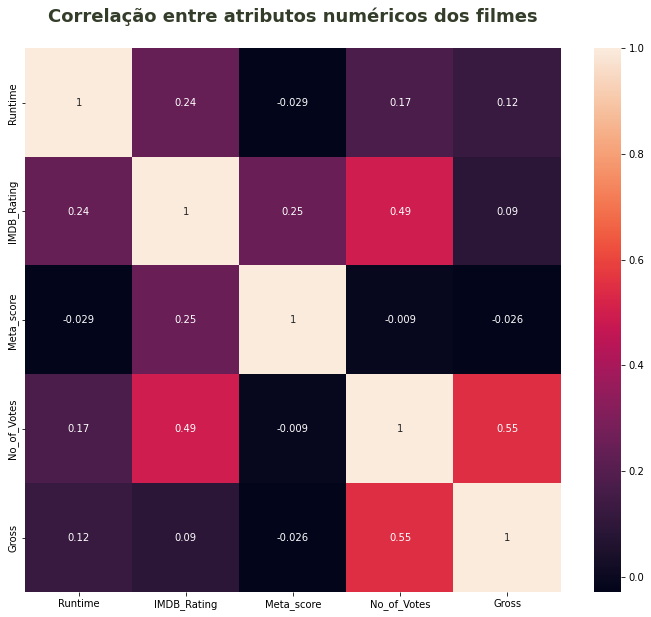

In [ ]:
plt.figure(figsize=(12,10))
plt.title('Correlação entre atributos numéricos dos filmes\n', fontsize=18, weight=600, color='#333d29')
sns.heatmap(dataset.corr(), annot=True)

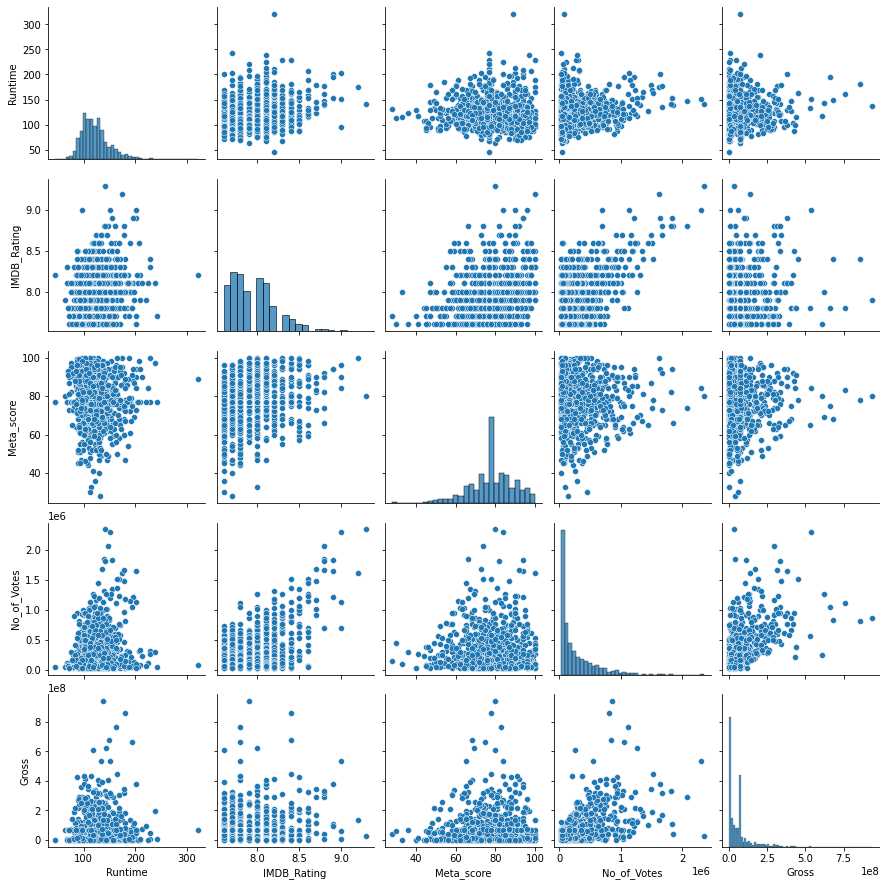

In [ ]:
sns.pairplot(dataset)

Uma análise interessante de ser realizada também é como esses atributos se comportam para cada gênero de filme. Para isso primeiro vamos selecionar os gêneros mais presentes dentro da lista de filmes melhor avaliados no IMDb.

In [ ]:
dataset['G1'].value_counts()

Drama        289
Action       172
Comedy       155
Crime        107
Biography     88
Animation     82
Adventure     72
Mystery       12
Horror        11
Western        4
Film-Noir      3
Fantasy        2
Family         2
Thriller       1
Name: G1, dtype: int64

Dessa forma nós temos que os gêneros mais presentes no Dataset são, respectivamente, Drama, Ação, Comédia, Crime, Biografia e Animação. Logo, vamos analisar como os seus respectivos atributos se correlacionam.

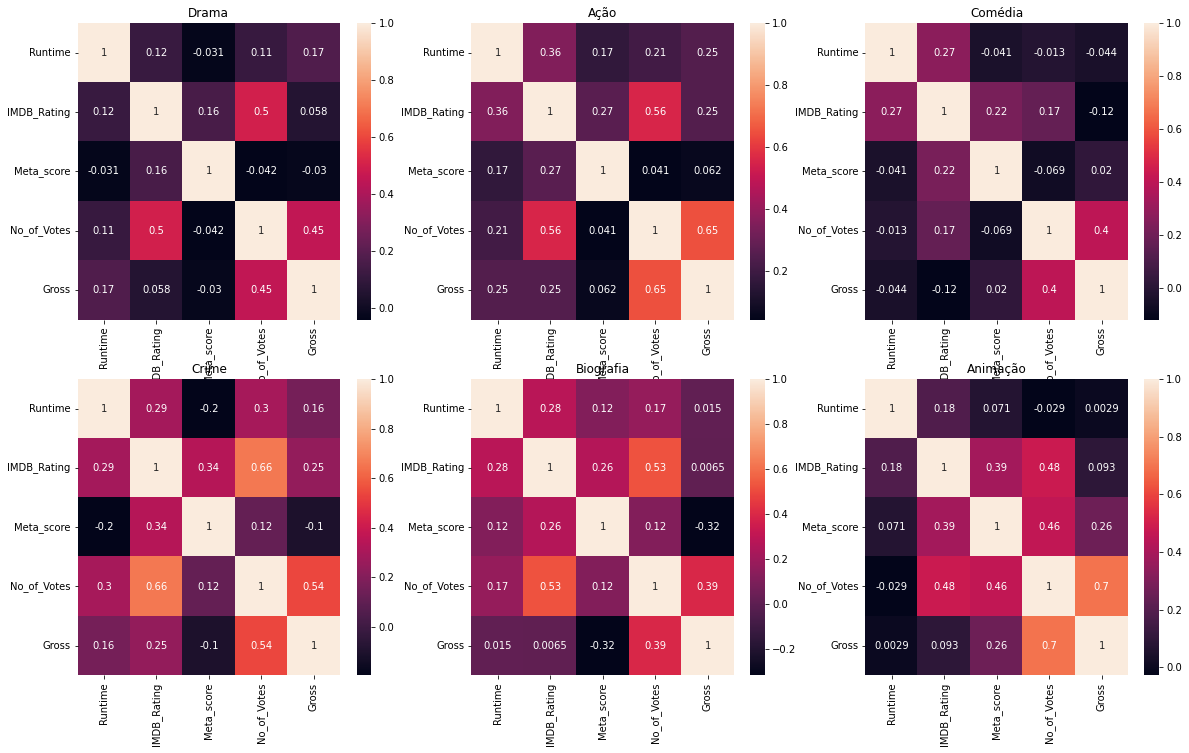

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(10, 10))
fig.set_figheight(12)
fig.set_figwidth(20)

# plt.title('Correlação entre atributos numéricos dos filmes\n', fontsize=18, weight=600, color='#333d29')
ax = plt.subplot(2,3,1)
ax.set_title('Drama')
sns.heatmap(dataset.groupby(['G1']).get_group('Drama').corr(), annot=True)

ax = plt.subplot(2,3,2)
ax.set_title('Ação')
sns.heatmap(dataset.groupby(['G1']).get_group('Action').corr(), annot=True)

ax = plt.subplot(2,3,3)
ax.set_title('Comédia')
sns.heatmap(dataset.groupby(['G1']).get_group('Comedy').corr(), annot=True)

ax = plt.subplot(2,3,4)
ax.set_title('Crime')
sns.heatmap(dataset.groupby(['G1']).get_group('Crime').corr(), annot=True)

ax = plt.subplot(2,3,5)
ax.set_title('Biografia')
sns.heatmap(dataset.groupby(['G1']).get_group('Biography').corr(), annot=True)

ax = plt.subplot(2,3,6)
ax.set_title('Animação')
sns.heatmap(dataset.groupby(['G1']).get_group('Animation').corr(), annot=True)

Pelos gráficos é perceptível que existe uma diferença considerável em relação a correlação entre os atributos dentro de cada gênero. Por exemplo, a relação entre o número de votos e do faturamento é muito maior para filmes de Animação e Ação do que para os outros tipos. Além disso, alguns gêneros possuem comportamentos únicos, como Biografia, em que existe uma dependência negativa do faturamento com a nota no Metacritic e Comédia, que é o único gênero em que a nota no IMBd e a quantidade de votos não possuem quase nenhuma relação.

### Análise de atributos gerais

Através desse primeiro gráfico podemos ver a distribuição dos filmes mais bem avaliados no IMDb em termos do seu ano de lançamento. De maneira geral, é possível observar que filmes lançados a partir dos anos 2000 predominam nessa lista. Quando observamos o gráfico de votos em relação ao ano lançado é possível verificar que a proporção de votos para quantidade de filmes é bem proporcional para filmes lançados após os anos 2000, mas filmes mais antigos, em média, receberam menos votos. Dessa forma, é possível inferir que filmes que foram lançados durante épocas em que a Internet já existia, fazendo com que a votação fosse mais fácil/acessível, tendem a receber mais votos.

In [ ]:
fig = px.histogram(data_frame=dataset.sort_values(by='Released_Year'), x='Released_Year')

fig.update_layout(title=dict(text='Distribuição de filmes de 1920 - atualmente',
                           font=dict(size=20), x=.5),
                 paper_bgcolor= 'white', plot_bgcolor='white', 
                 xaxis = dict(title='Ano de lançamento', showgrid=True),
                 yaxis=dict(showgrid=True))

In [ ]:
fig = px.bar(dataset.sort_values(by='Released_Year'), x='Released_Year', y='No_of_Votes')

fig.update_layout(title=dict(text='Ano de lançamento x Número de Votos recebidos',
                           font=dict(size=20), x=.5),
                 paper_bgcolor= 'white', plot_bgcolor='white', 
                 xaxis = dict(title='Ano de lançamento', showgrid=True),
                 yaxis=dict(showgrid=True))

Através dos gráficos de Density Plot e do Histograma podemos analisar a distribuição do Metascore, Runtime, Número de Votos e Faturamento. A partir dos gráficos, podemos fazer as seguinte observações sobre os top 1000 filmes:
- A distribuição da duração dos filmes é a mais uniforme, sendo que ela possui uma média de 122 e desvio padrão de 28
- A distribuição do número de votos é altamente desviada para a esquerda, sendo que grande parte dos filmes possuem menos que 100k votos
- A distribuição do faturamento dos filmes também é altamente desviada para a esquerda, de maneira que a grande maioria dos filmes possuem um faturamento inferior a 100mi, sendo mais do que 50% possuem um faturameto menor do que 50mi

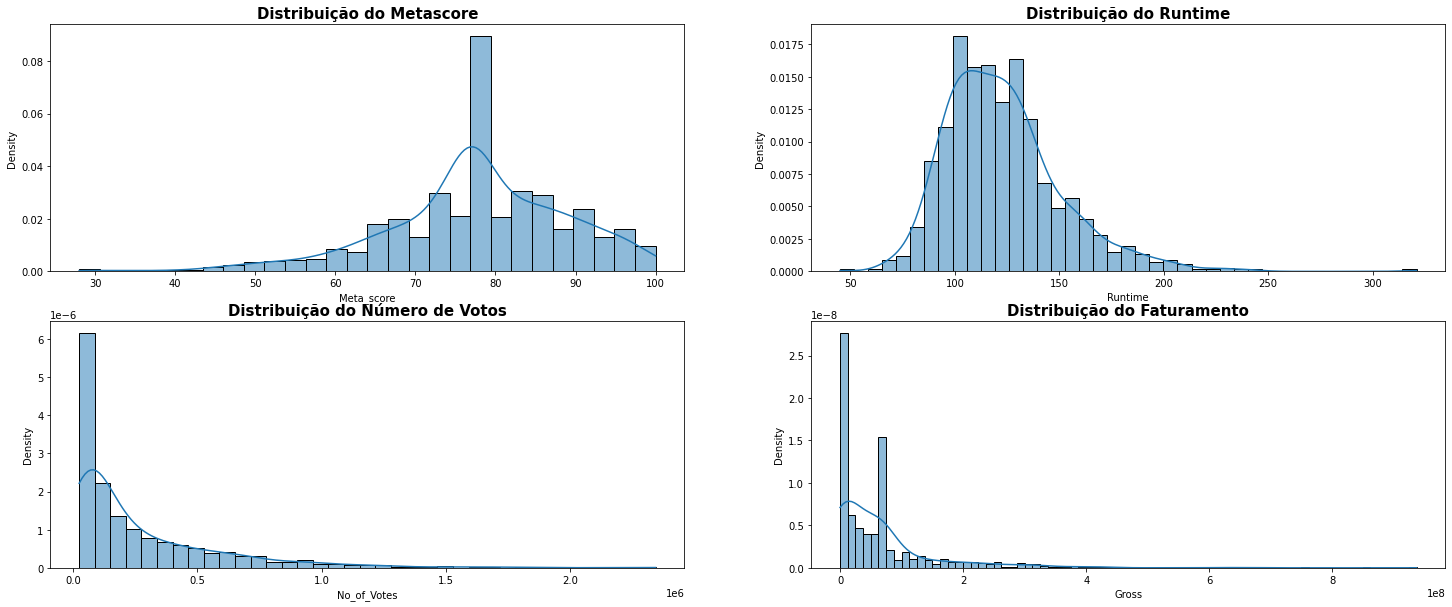

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 25))
fig.set_figheight(10)
fig.set_figwidth(25)

# plt.title('Correlação entre atributos numéricos dos filmes\n', fontsize=18, weight=600, color='#333d29')
ax = plt.subplot(2,2,1)
ax.set_title('Distribuição do Metascore', fontsize=15, weight=600)
sns.histplot(dataset['Meta_score'], kde=True, stat="density", linewidth=1)

ax = plt.subplot(2,2,2)
ax.set_title('Distribuição do Runtime', fontsize=15, weight=600)
sns.histplot(dataset['Runtime'], kde=True, stat="density", linewidth=1)

ax = plt.subplot(2,2,3)
ax.set_title('Distribuição do Número de Votos', fontsize=15, weight=600)
sns.histplot(dataset['No_of_Votes'], kde=True, stat="density", linewidth=1)

ax = plt.subplot(2,2,4)
ax.set_title('Distribuição do Faturamento', fontsize=15, weight=600)
sns.histplot(dataset['Gross'], kde=True, stat="density", linewidth=1)

In [ ]:
dataset.describe()

,Runtime,IMDB_Rating,Meta_score,No_of_Votes,Gross
count,1000.000000,1000.000000,1000.000000,1.000000e+03,1.000000e+03
mean,122.891000,7.949300,77.819000,2.736929e+05,6.803475e+07
std,28.093671,0.275491,11.367562,3.273727e+05,1.000371e+08
min,45.000000,7.600000,28.000000,2.508800e+04,1.305000e+03
25%,103.000000,7.700000,72.000000,5.552625e+04,5.012919e+06
50%,119.000000,7.900000,77.000000,1.385485e+05,4.238945e+07
75%,137.000000,8.100000,85.250000,3.741612e+05,6.803475e+07
max,321.000000,9.300000,100.000000,2.343110e+06,9.366622e+08


In [ ]:
dataset.loc[dataset['Director'] == 'Anthony Russo']

,Series_Title,Released_Year,Runtime,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross,G1,G2,G3
59,Avengers: Endgame,2019,181.0,8.4,After the devastating events of Avengers: Infi...,78.0,Anthony Russo,Joe Russo,Robert Downey Jr.,Chris Evans,Mark Ruffalo,809955,858373000.0,Action,Adventure,Drama
60,Avengers: Infinity War,2018,149.0,8.4,The Avengers and their allies must be willing ...,68.0,Anthony Russo,Joe Russo,Robert Downey Jr.,Chris Hemsworth,Mark Ruffalo,834477,678815482.0,Action,Adventure,Sci-Fi
583,Captain America: Civil War,2016,147.0,7.8,Political involvement in the Avengers' affairs...,75.0,Anthony Russo,Joe Russo,Chris Evans,Robert Downey Jr.,Scarlett Johansson,663649,408084349.0,Action,Adventure,Sci-Fi
737,Captain America: The Winter Soldier,2014,136.0,7.7,As Steve Rogers struggles to embrace his role ...,70.0,Anthony Russo,Joe Russo,Chris Evans,Samuel L. Jackson,Scarlett Johansson,736182,259766572.0,Action,Adventure,Sci-Fi


Através de Bar Plots podemos analisar também o impacto da presença de determinados diretores para que o filme apareça na lista dos melhores avaliados e também em relação aos diretores com os maiores faturamentos considerando os filmes da lista que eles dirigiram. A partir dos gráficos podemos fazer as seguinte observações:
- Os 10 diretores dentre os 548 com maior presença na lista de filmes mais bem avaliados do IMDb dirigem 10% de todos os filmes presentes na lista
- Apesar de Alfred Hitchcock ser o diretor que conseguiu emplacar mais filmes no Top 1000 ele não aparece na lista de diretores com maior faturamento
- Apesar de Anthony Russo ter dirigido apenas 4 filmes presentes no Dataset ele ocupa a segunda posição de faturamento total com os seus filmes
- 8 dos 10 diretores com mais aparições não fazem parte da lista de diretores com maior faturamento cumulativo

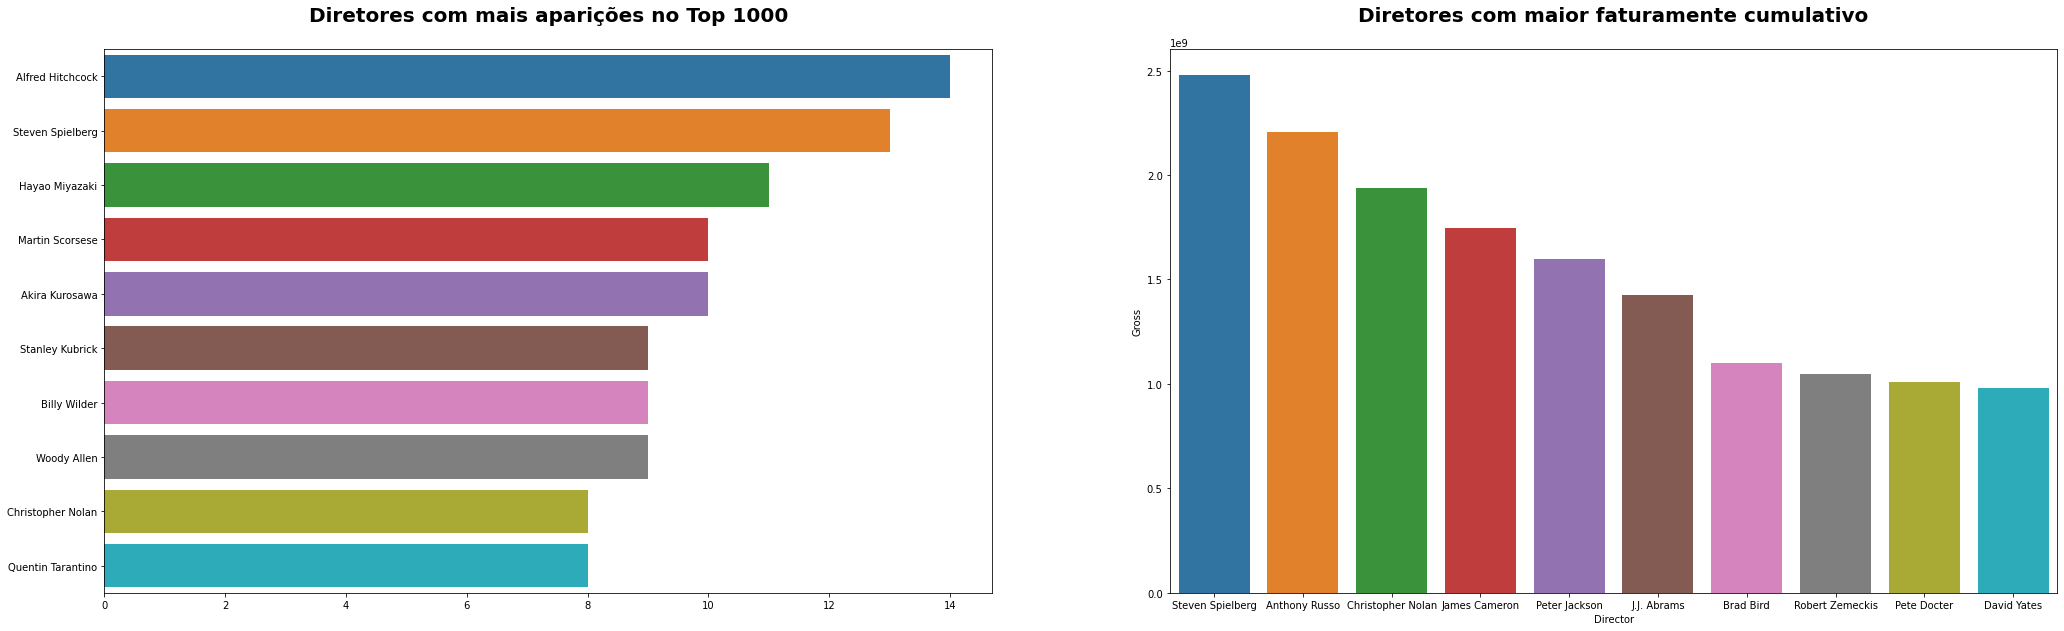

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20, 15))
fig.set_figheight(10)
fig.set_figwidth(35)

ax = plt.subplot(1,2,1)
ax.set_title('Diretores com mais aparições no Top 1000\n', fontsize=20, weight=600)
sns.barplot(x=dataset['Director'].value_counts().values[:10], y=dataset['Director'].value_counts().keys()[:10])

ax = plt.subplot(1,2,2)
ax.set_title('Diretores com maior faturamente cumulativo\n', fontsize=20, weight=600)
sns.barplot(y=dataset.groupby('Director').sum().sort_values(by='Gross', ascending=False)['Gross'][:10], x=dataset.groupby('Director').sum().sort_values(by='Gross', ascending=False).index[:10])

Os Barplots podem ser utilizados também para a análise da frequência dos atores e atrizes dentro da lista de filmes. As seguinte observações podem ser feitas a partir dos gráficos:
- Apenas 2 mulheres estão na lista de top 30 atores/atrizes e nenhuma está na lista de top 15 estrelas principais
- Robert De Niro é o ator que mais realiza aparições no Top 1000 mas fica atrás de Tom Hanks na lista de estrelas principais
- Daniel Radcliffe aparece na lista de atores com mais aparições como estrelas principais porém está foram da lista de atores com mais aparições gerais
- Os atores presente nas quatro primeiras posições das duas listas são iguais, com apenas uma inversão do primeiro e segundo lugar

In [ ]:
df = pd.DataFrame(dataset)

df = pd.concat([df['Star1'], df['Star2'], df['Star3'], df['Star4']])

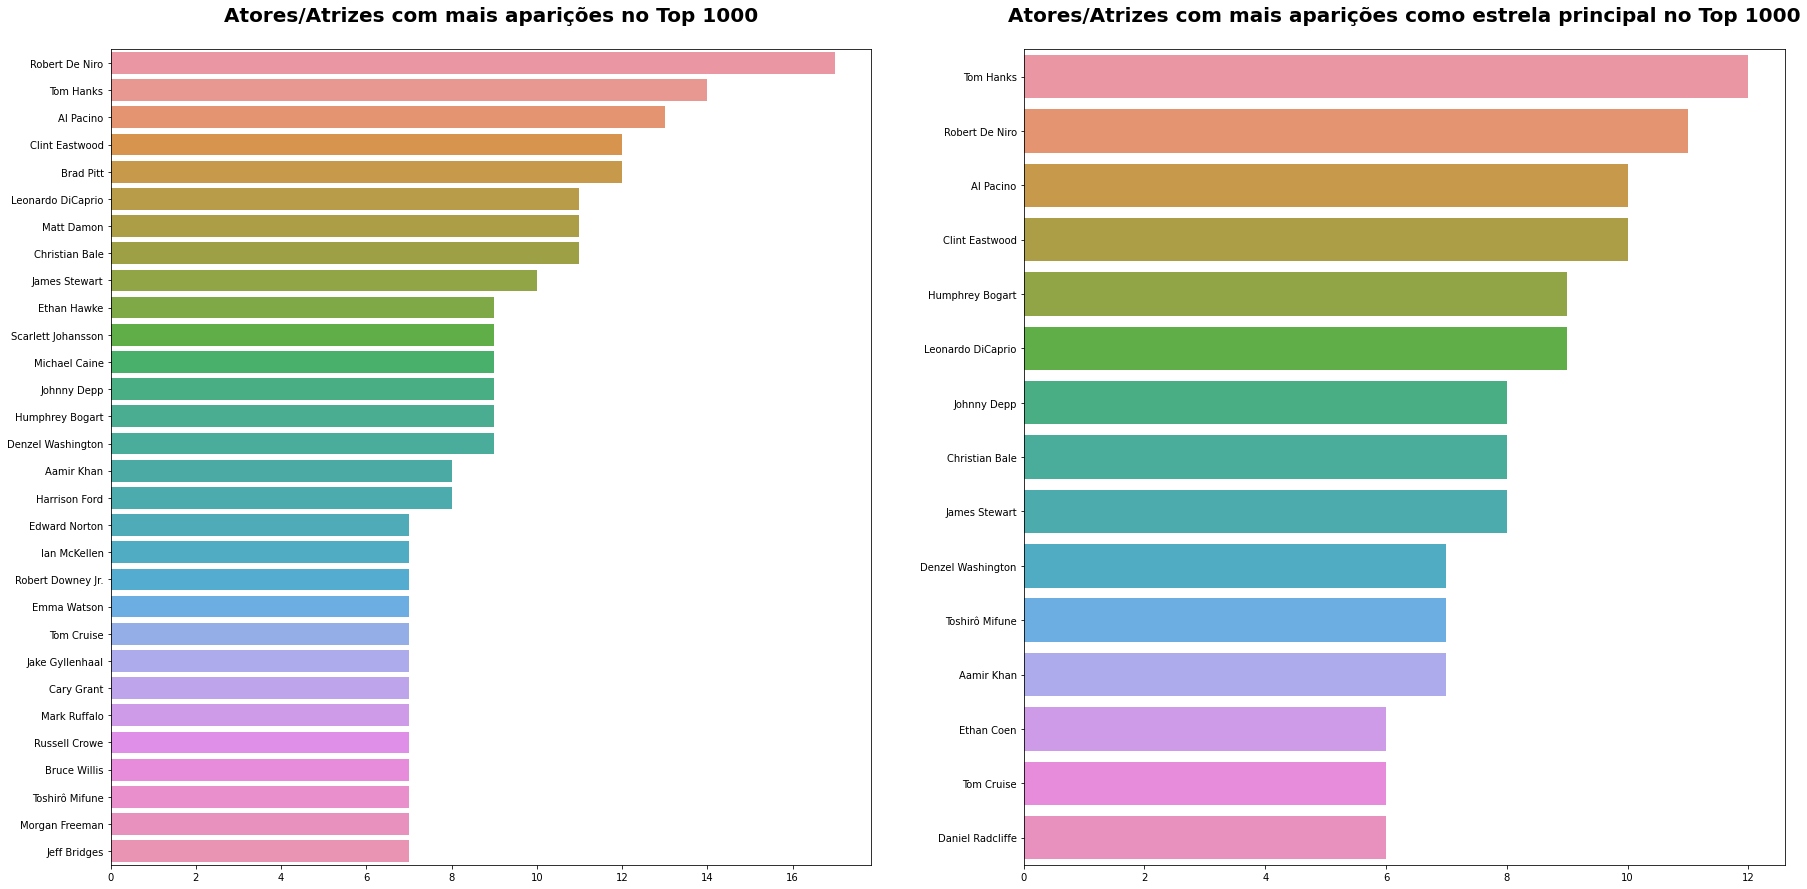

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20, 15))
fig.set_figheight(15)
fig.set_figwidth(30)

ax = plt.subplot(1,2,1)
ax.set_title('Atores/Atrizes com mais aparições no Top 1000\n', fontsize=20, weight=600)
sns.barplot(y=df.value_counts().keys()[:30], x=df.value_counts().values[:30])

ax = plt.subplot(1,2,2)
ax.set_title('Atores/Atrizes com mais aparições como estrela principal no Top 1000\n', fontsize=20, weight=600)
sns.barplot(y=dataset['Star1'].value_counts().keys()[:15], x=dataset['Star1'].value_counts().values[:15])

### Análise por gênero

Quanto a análise por gênero, primeiramente podemos verificar que os filmes mais bem avaliados são majoritariamente pertencentes aos gêneros Drama, Ação e Comédia, respectivamente.

(-1.25, 1.25, -1.25, 1.25)

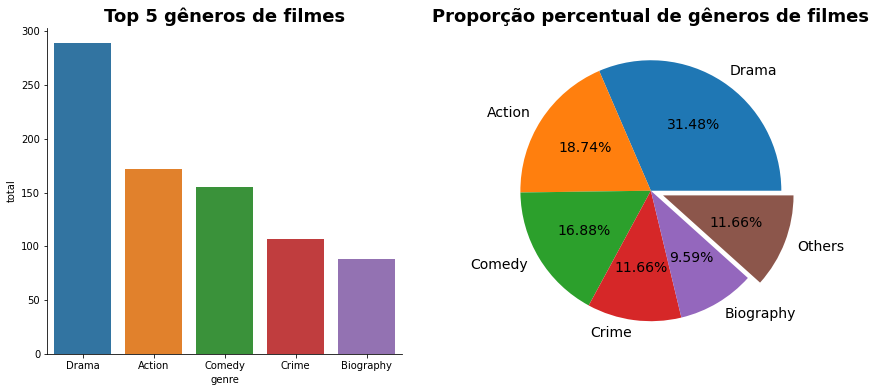

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,6))

df_plot = pd.DataFrame(Counter(dataset['G1']).most_common(5), columns=['genre', 'total'])
ax = sns.barplot(data=df_plot, x='genre', y='total', ax=axes[0])
ax.set_title('Top 5 gêneros de filmes', fontsize=18, weight=600)
sns.despine()

df_plot_full = pd.DataFrame([Counter(dataset['G1'])]).transpose().sort_values(by=0, ascending=False)
df_plot.loc[len(df_plot)] = {'genre': 'Others', 'total':df_plot_full[6:].sum()[0]} #Outros gêneros presentes no dataset
plt.title('Proporção percentual de gêneros de filmes', fontsize=18, weight=600)
wedges, texts, autotexts = axes[1].pie(x=df_plot['total'], labels=df_plot['genre'], autopct='%.2f%%',
                                       textprops=dict(fontsize=14), explode=[0,0,0,0,0,0.1])


axes[1].axis('off')

Podemos analisar também como cada um dos gêneros se comportam em relação a alguns atributos, como tamanho do filme (Runtime), nota no IMDb, quantidade de votos e faturamento por meio do uso do Boxplot. 
<br>
<br>
De maneira geral, é possível ver que em todas as comparações existem um número razoável de outliers, sendo que os que se destacam são o gênero Drama em relação a Runtime e Número de Votos e o gênero de Ação em relação ao Faturamento. Considerando que o conjunto de dados é formado pelos 1000 filmes melhor avaliados de todos os tempos na plataforma, é esperado que existam outliers mesmo dentro essa seleção dos Top 1000, já que estamos considerando filmes considerados excepcionais pelo público.
<br>
<br>
Ainda assim, podemos extrair algumas informações:
- O gênero com menos popularidade é o de Comédia.
- Filmes de Ação tem maior arrecadamento que os outros
- Filmes de ação, no geral, possuem maior número de votos

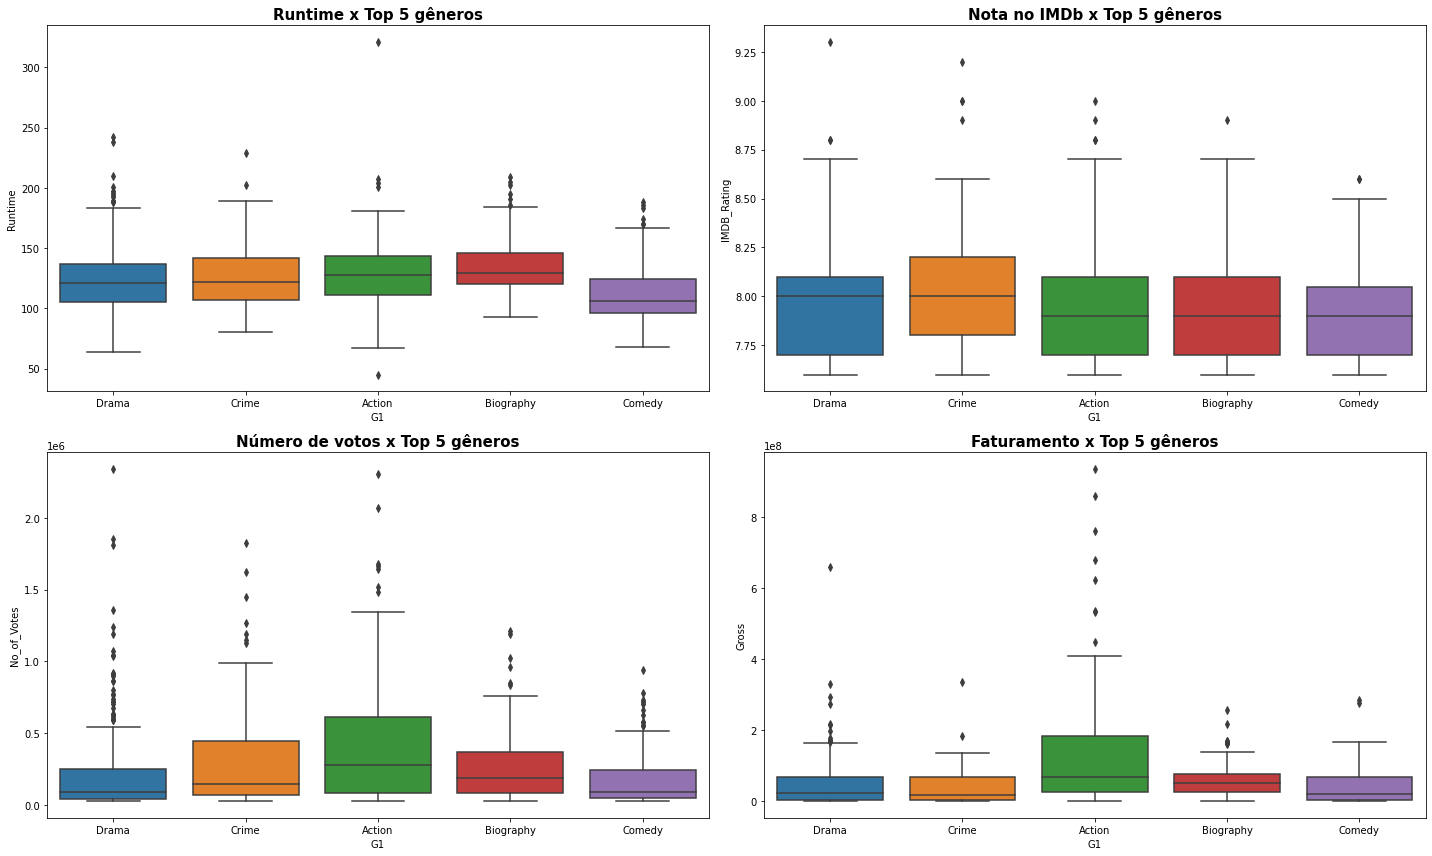

In [ ]:
df_plot = pd.DataFrame(Counter(dataset['G1']).most_common(5), columns=['genre', 'total'])
df_plot = dataset[dataset['G1'].isin(df_plot['genre'].to_numpy())]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,12))
titles = ['Runtime x Top 5 gêneros', 'Nota no IMDb x Top 5 gêneros', 'Número de votos x Top 5 gêneros', 'Faturamento x Top 5 gêneros']

for i, y in enumerate(['Runtime', 'IMDB_Rating', 'No_of_Votes', 'Gross']):
  sns.boxplot(data=df_plot, x='G1', y=y, ax=axes.flatten()[i]).set_title(titles[i], fontsize=15, weight=600)

plt.tight_layout()

Uma análise que pode ser feita também é sobre as principais palavras presentes nas descrições dos filmes de cada gênero. Para isso, primeiramente retiramos as stopwords, ou seja, palavras sem valor semântico, das descrições e passamos todas os resumos, separados pelos gêneros dos filmes, para o algoritmo de WordCloud, de maneira que ele represente visualmente quais foram as palavras mais utilizadas e relevantes dentro de cada contexto.
<br>
<br>
Com base nos resultados, podemos ver que existem algumas palavras mais frequêntes em cada gênero, como:
- **Drama**: "find", "life", "man", "father", "love", "family", "wife" (várias palavras associadas ao contexto familiar)
- **Ação**: "one", "man", "must", "find", "world", "battle", "lead", "team", "agent" (várias palavras relacionadas a contextos de guerra ou ação)
- **Comédia**: "love", "life", "young", "two", "man", "friend", "family" (palavras relacionadas a família/amigos/dia-a-dia)
- **Crime**: "crime", "murder", "young", "man", "police", "killer", "detective" (palavras relacionadas a crime e investigação)
- **Biografia**: "American", "life", "story", "war", "king", "true" (palavras relacionadas a eventos)
- **Animação**: "young", "girl", "world", "toy", "family", "find" (palavras relacionadas a temas infantis e de família)

In [ ]:
stop = stopwords.words('english')
test = pd.DataFrame(dataset)[['Overview', 'G1']]
test['Overview'] = test['Overview'].apply(lambda x: [palavra for palavra in x.split() if palavra not in stop])
test['Overview'] = test['Overview'].apply(lambda x : ' '.join(x))
test

,Overview,G1
0,"Two imprisoned men bond number years, finding ...",Drama
1,An organized crime dynasty's aging patriarch t...,Crime
2,When menace known Joker wreaks havoc chaos peo...,Action
3,The early life career Vito Corleone 1920s New ...,Crime
4,A jury holdout attempts prevent miscarriage ju...,Crime
...,...,...
995,A young New York socialite becomes interested ...,Comedy
996,Sprawling epic covering life Texas cattle ranc...,Drama
997,"In Hawaii 1941, private cruelly punished boxin...",Drama
998,Several survivors torpedoed merchant ship Worl...,Drama


(-0.5, 2999.5, 1499.5, -0.5)

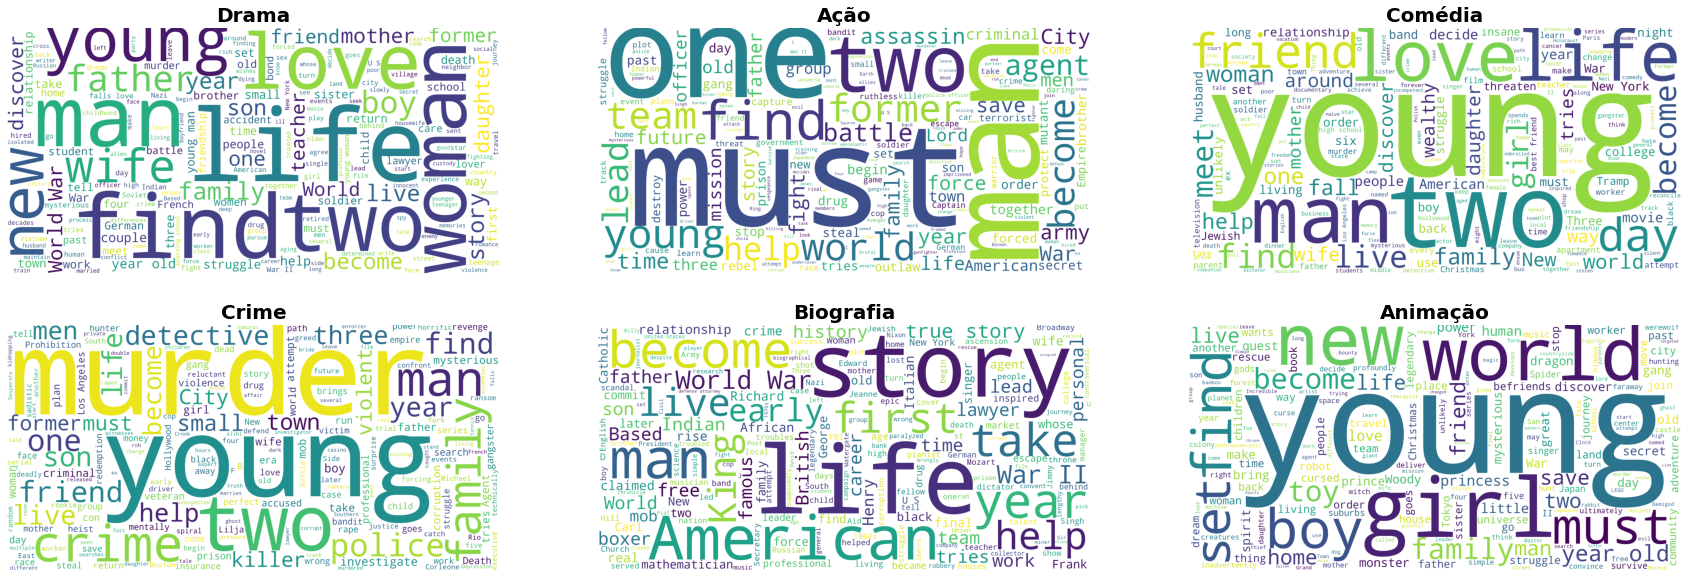

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(20, 15))
fig.set_figheight(10)
fig.set_figwidth(30)

# plt.title('Correlação entre atributos numéricos dos filmes\n', fontsize=18, weight=600, color='#333d29')
ax = plt.subplot(2,3,1)
ax.set_title('Drama', fontsize=20, weight=600)
wc = WordCloud(max_words=200, min_font_size=20,height=1500,width=3000,background_color="white").generate(' '.join(test.loc[test['G1'] == 'Drama']['Overview']))
plt.imshow(wc)
ax.axis('off')

ax = plt.subplot(2,3,2)
ax.set_title('Ação', fontsize=20, weight=600)
wc = WordCloud(max_words=200, min_font_size=20,height=1500,width=3000,background_color="white").generate(' '.join(test.loc[test['G1'] == 'Action']['Overview']))
plt.imshow(wc)
ax.axis('off')

ax = plt.subplot(2,3,3)
ax.set_title('Comédia', fontsize=20, weight=600)
wc = WordCloud(max_words=200, min_font_size=20,height=1500,width=3000,background_color="white").generate(' '.join(test.loc[test['G1'] == 'Comedy']['Overview']))
plt.imshow(wc)
ax.axis('off')

ax = plt.subplot(2,3,4)
ax.set_title('Crime', fontsize=20, weight=600)
wc = WordCloud(max_words=200, min_font_size=20,height=1500,width=3000,background_color="white").generate(' '.join(test.loc[test['G1'] == 'Crime']['Overview']))
plt.imshow(wc)
ax.axis('off')

ax = plt.subplot(2,3,5)
ax.set_title('Biografia', fontsize=20, weight=600)
wc = WordCloud(max_words=200, min_font_size=20,height=1500,width=3000,background_color="white").generate(' '.join(test.loc[test['G1'] == 'Biography']['Overview']))
plt.imshow(wc)
ax.axis('off')

ax = plt.subplot(2,3,6)
ax.set_title('Animação', fontsize=20, weight=600)
wc = WordCloud(max_words=200, min_font_size=20,height=1500,width=3000,background_color="white").generate(' '.join(test.loc[test['G1'] == 'Animation']['Overview']))
plt.imshow(wc)
ax.axis('off')